In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
print(plt.rcParamsDefault['figure.figsize'])

plt.rcParams = plt.rcParamsDefault

[8.0, 6.0]


In [3]:
#Here I want to test some regressors

import numpy as np
import h5py
#from sklearn.gaussian_process import GaussianProcess
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split

In [4]:
f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')

print(f['PartType1'].keys())
coords = f['PartType1']['Coordinates'][:]
dm_mass = f['PartType1']['Masses'][0]
vel = f['PartType1']['Velocities'][:]
mass_ratio = f['PartType1']['Stellar_Masses'][:]

<ipython-input-4-6d70ec4755f7>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')
<ipython-input-4-6d70ec4755f7>:15: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')


<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Stellar_Masses', 'Velocities']>


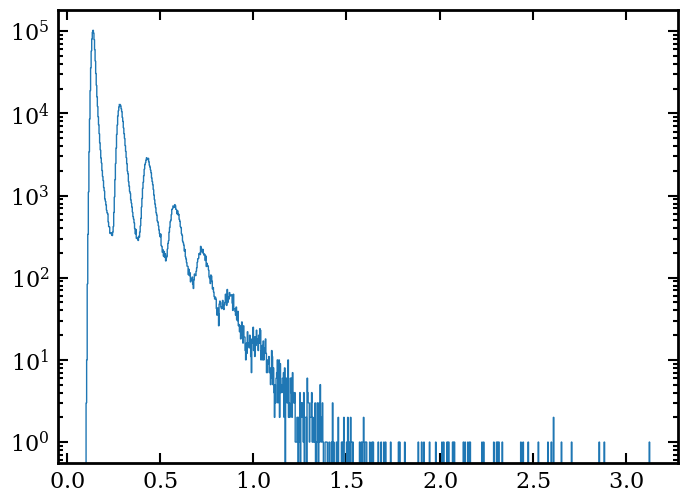

In [5]:
Mass_ratio = mass_ratio/dm_mass

plt.hist(Mass_ratio[Mass_ratio>0.0],bins=1000,histtype='step')
plt.yscale('log')
plt.show()

In [14]:
print(Mass_ratio)

[0.1441821  0.15505835 0.15204261 ... 0.         0.         0.        ]


In [87]:
f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')

print(f['PartType1'].keys())
coords = f['PartType1']['Coordinates'][:]
dm_mass = f['PartType1']['Masses'][0]
vel = f['PartType1']['Velocities'][:]
mass_ratio = f['PartType1']['Stellar_Masses'][:]
Mass_ratio = mass_ratio/dm_mass


#1) attempt to save memory by reducing number of points                                                               
#   remove everything outside 400 kpc (these shouldn't)                                                               
#   factor in anyways                                                                                                 

#I think I need to merge coords and vel into a                                                                        
#2X6 array                                                                                                            

#Now this matrix is so large we run into memory errors                                                                
#                                                                                                                     
#A few potential solutions:                                                                                           
# 1) reduce the number of input points (limit to dm part within 400 kpc?) [NOPE]                                      
# 2) change algorithm (some might require less memory or some option)                                                 
#    may reduce memory                                                                                                
#    - Try using GaussianProccessRegressor module [X]                                                                 
#    - Try "bagging"                                                                                                  
# 3) run on a processor with more memory or figure out how to parallelize                                             

print('splitting data')

phase_space_coords =  np.concatenate((coords-host_pos,vel-host_vel),axis=1)

X_train, X_test, y_train, y_test = train_test_split(phase_space_coords[Mass_ratio>0.0],Mass_ratio[Mass_ratio>0.0],
                                                    test_size=0.2,random_state=0)

#Now I can use the GaussianProcess to predict                                                                        

<ipython-input-87-7f479df8a6ce>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')
<ipython-input-87-7f479df8a6ce>:15: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')


<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Stellar_Masses', 'Velocities']>
splitting data


In [92]:
print('linear fit')
LR = LinearRegression()
LR.fit(X_train[:,0:3],y_train)

print('Lasso fit')
LassoR = Lasso()
LassoR.fit(X_train[:,0:3],y_train)

print('Ridge fit')
RidgeR = Ridge()
RidgeR.fit(X_train[:,0:3],y_train)

f.close()
f_halo.close()

linear fit
Lasso fit
Ridge fit


In [94]:
#train_test_split will split a number of arrays into a training sample and a test sample
#example:

mass_ratio_LR = LR.predict(X_test[:,0:3])
mass_ratio_Lasso = LassoR.predict(X_test[:,0:3])
mass_ratio_Ridge = RidgeR.predict(X_test[:,0:3])

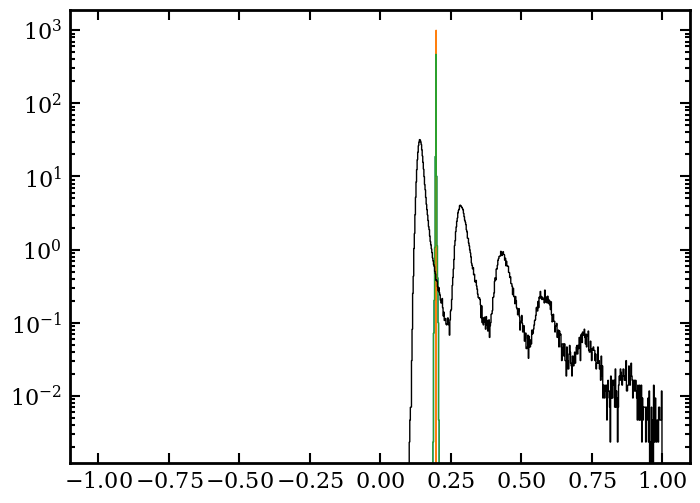

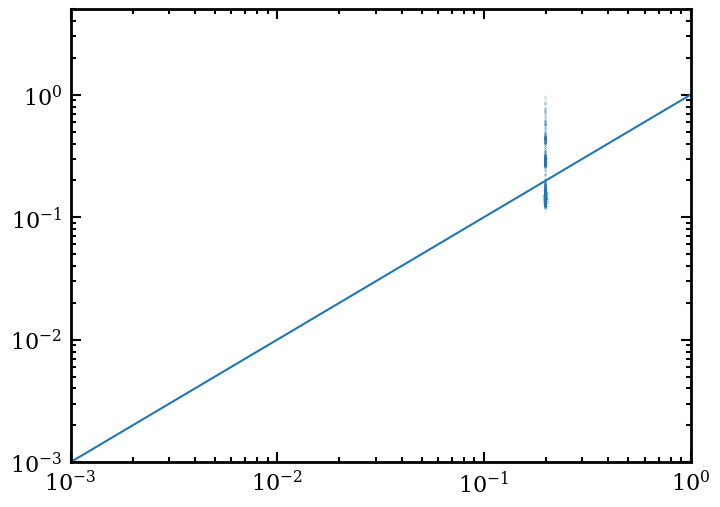

In [95]:
#LR_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_LR)),y_test)
#Lasso_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_Lasso)),y_test)
#Ridge_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_Ridge)),y_test)

#plt.hist(LR_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C0',normed=True)
#plt.hist(Lasso_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C1',normed=True)
#plt.hist(Ridge_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C2',normed=True)
#plt.show()

#print np.min(y_test), np.max(y_test)
#print np.mean(y_test)
#print len(y_test[::100])

#print np.min(mass_ratio_LR), np.max(mass_ratio_LR)
#print np.mean(mass_ratio_LR)
hist_bins = np.linspace(-1.0,1.0,1000)

norm_val = False

plt.hist(mass_ratio_LR,bins=hist_bins,histtype='step',color='C0',density=True)
plt.hist(mass_ratio_Lasso,bins=1000,histtype='step',color='C1',density=True)
plt.hist(mass_ratio_Ridge,bins=hist_bins,histtype='step',color='C2',density=True)
plt.hist(y_test,bins=hist_bins,histtype='step',color='k',density=True)
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(mass_ratio_LR[::100],y_test[::100],s=0.01)
plt.plot([0.001,5.0],[0.001,5.0])
plt.xlim([0.001,1.0])
plt.ylim([0.001,5.0])
plt.xscale('log')
plt.yscale('log')
plt.show()


In [96]:
#Now try polynomial regressors

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(5),LinearRegression())
model.fit(X_train[:,0:3],y_train)
mass_ratio_poly = model.predict(X_test[:,0:3])

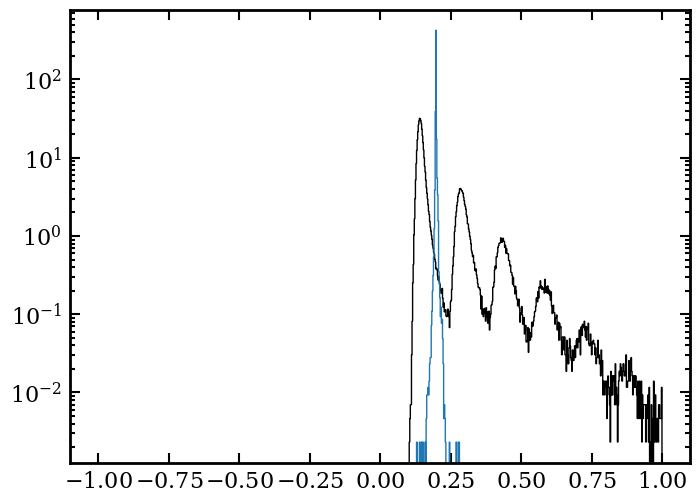

In [97]:
hist_bins = np.linspace(-1.0,1.0,1000)

plt.hist(y_test,bins=hist_bins,histtype='step',color='k',density=True)
plt.hist(mass_ratio_poly,bins=hist_bins,histtype='step',color='C0',density=True)
#plt.xscale('log')
plt.yscale('log')
plt.show()


In [18]:
#This is the output from a Gaussian process regressor, which takes up too much memory to run locally

f_test = h5py.File('test_data.hdf5')
f_test.keys()

<ipython-input-18-08929367c6c5>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_test = h5py.File('test_data.hdf5')


<KeysViewHDF5 ['X_test', 'X_train', 'y_test', 'y_train']>

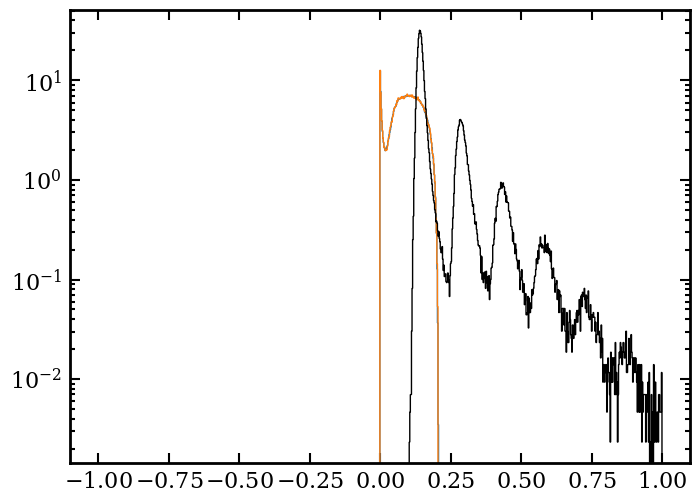

In [25]:
X_train_test = f_test['X_train'][:]
X_test_test = f_test['X_test'][:]
y_train_test = f_test['y_train'][:]
y_test_test = f_test['y_test'][:]

plt.hist(y_train_test,bins=hist_bins,color='C0',histtype='step',density=True)
plt.hist(y_test_test,bins=hist_bins,color='C1',histtype='step',density=True)
plt.hist(y_test,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')

plt.show()

In [7]:
from astroML.linear_model import PolynomialRegression

model = PolynomialRegression(5)
model.fit(X_train,y_train)
mass_ratio_poly = model.predict(X_test)

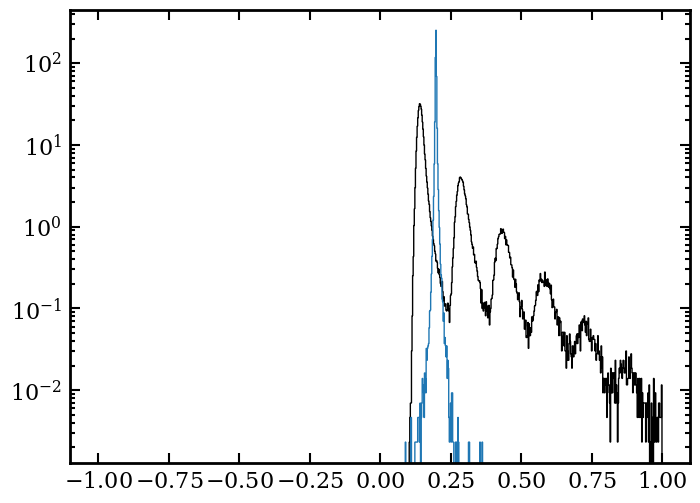

In [8]:
hist_bins = np.linspace(-1.0,1.0,1000)

plt.hist(y_test,bins=hist_bins,histtype='step',color='k',density=True)
plt.hist(mass_ratio_poly,bins=hist_bins,histtype='step',color='C0',density=True)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
from astroML.linear_model import NadarayaWatson

model=NadarayaWatson('gaussian', 0.05)
model.fit(X_train,y_train)
mass_ratio_NW = model.predict(X_test)

plt.hist(y_test,bins=hist_bins,histtype='step',color='k',density=True)
plt.hist(mass_ratio_NW,bins=hist_bins,histtype='step',color='C0',density=True)
#plt.xscale('log')
plt.yscale('log')
plt.show()

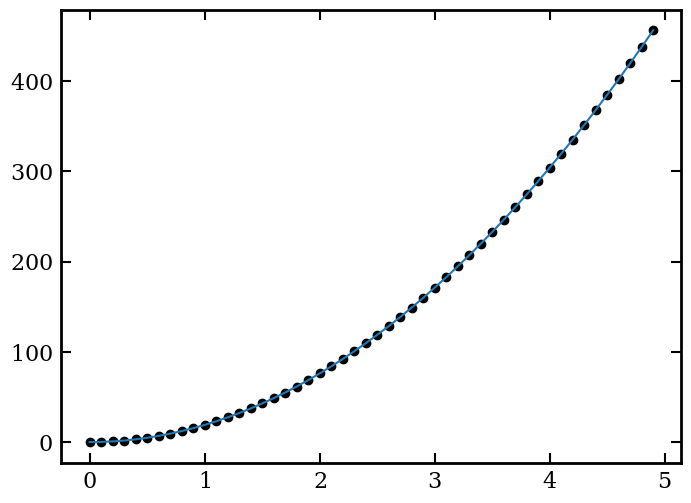

In [53]:
#Okay lets try generating some fake data and train on it

X_fake_1 = np.arange(0.0, 5.0, 0.1, dtype='float32')
X_fake_2 = np.arange(0.0, 5.0, 0.1, dtype='float32')
X_fake_3 = np.arange(0.0, 5.0, 0.1, dtype='float32')
X_fake_4 = np.arange(0.0, 5.0, 0.1, dtype='float32')
X_fake_5 = np.arange(0.0, 5.0, 0.1, dtype='float32')
#y_fake = 5 * np.power(np.arange(0.0, 5.0, 0.1, dtype='float32'),2) + np.power(np.random.randn(50),3)

X_fake = np.concatenate((X_fake_1.reshape(-1,1),X_fake_2.reshape(-1,1),X_fake_3.reshape(-1,1),X_fake_4.reshape(-1,1),X_fake_5.reshape(-1,1)),axis=1)

y_fake = X_fake_1**2.0+2.0*X_fake_2**2.0+15.0*X_fake_3**2.0+X_fake_4**2.0

model = PolynomialRegression(2)
model.fit(X_fake,y_fake)
fake_fit = model.predict(X_fake)

plt.scatter(X_fake_5,y_fake,color='k')
plt.plot(X_fake_5,fake_fit)
plt.show()

In [78]:
X_rand = np.random.rand(100,3)
V_rand = np.random.rand(100,3)

#X_rand = np.random.normal(size=(1000,3))
#V_rand = np.random.normal(size=(1000,3))

mr_rand = 1.0/X_rand[:,0]+1.0/X_rand[:,1]+1.0/X_rand[:,2]+1.0/V_rand[:,0]+1.0/V_rand[:,1]+1.0/V_rand[:,2]

[]

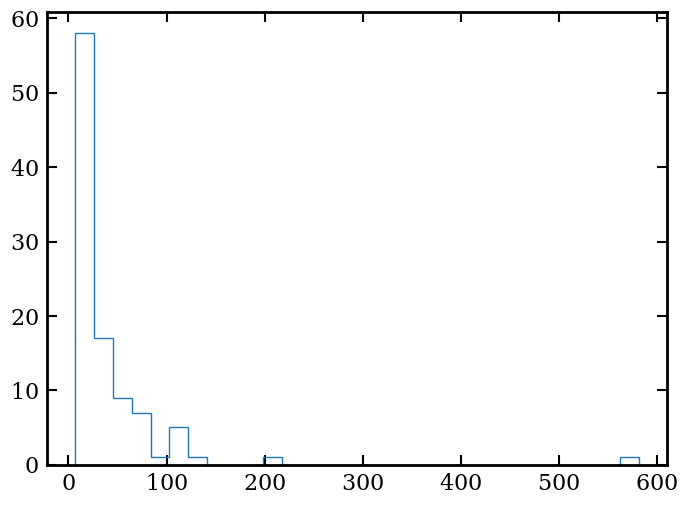

In [79]:
plt.hist(mr_rand,bins=30,histtype='step')
plt.plot()

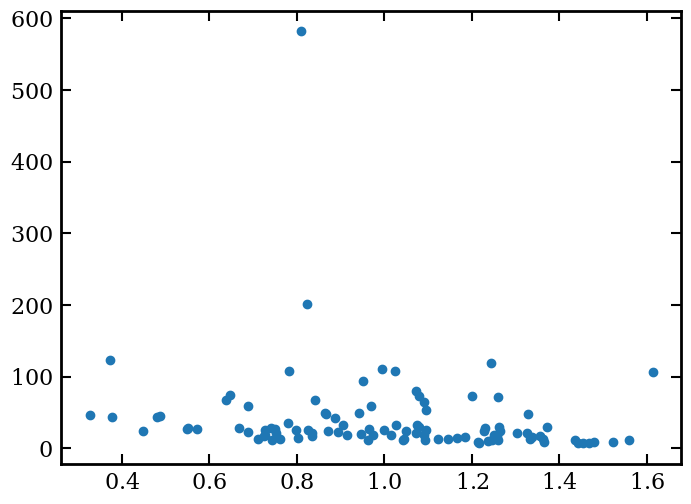

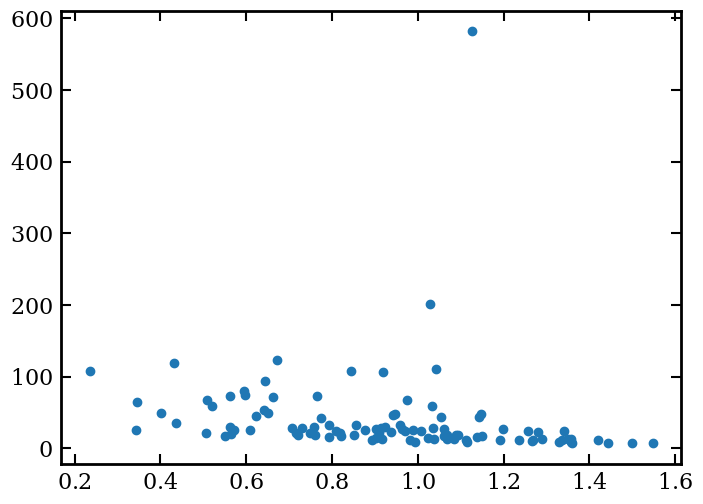

In [81]:
dist = np.linalg.norm(X_rand,axis=1)
vel = np.linalg.norm(V_rand,axis=1)

plt.scatter(dist,mr_rand)
plt.show()

plt.scatter(vel,mr_rand)
plt.show()

In [84]:
model = PolynomialRegression(2)

X_fake = np.concatenate((X_rand,V_rand),axis=1)

model.fit(X_fake,mr_rand)
fake_fit = model.predict(X_fake)

#plt.scatter(,y_fake,color='k')
#plt.plot(X_fake_5,fake_fit)
#plt.show()

[]

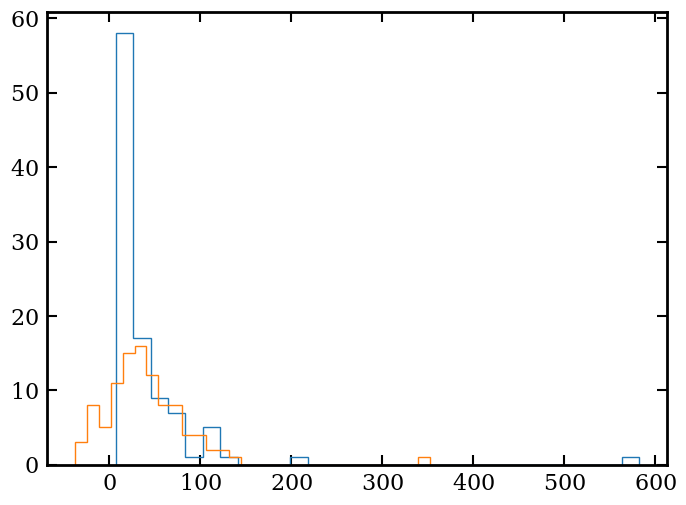

In [85]:
plt.hist(mr_rand,bins=30,histtype='step')
plt.hist(fake_fit,bins=30,histtype='step')
plt.plot()

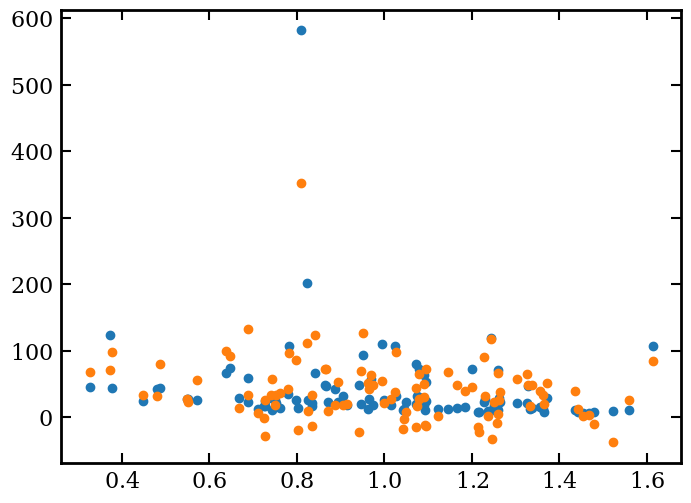

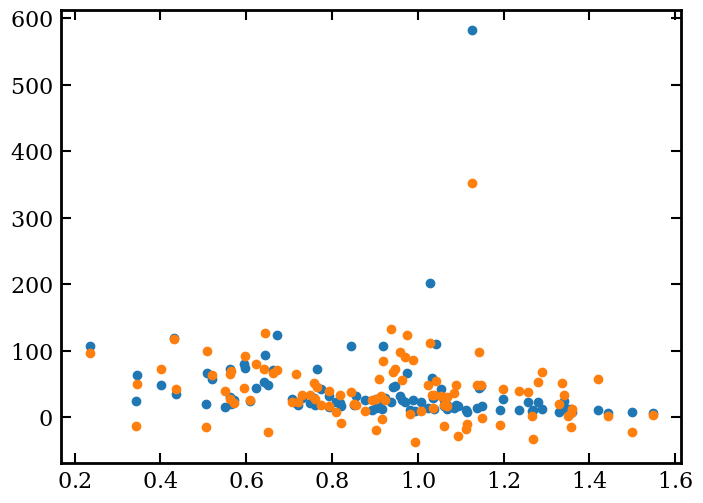

In [86]:
plt.scatter(dist,mr_rand)
plt.scatter(dist,fake_fit)
plt.show()

plt.scatter(vel,mr_rand)
plt.scatter(vel,fake_fit)
plt.show()

In [91]:
X_test[:,0:3]

array([[ -8.89918568,   6.84437059,   1.40197043],
       [ -7.34802777,  -4.75081938,   1.97678741],
       [  6.51876246,   0.42599001, -14.60982398],
       ...,
       [ -4.01737435,   3.32141186,  -6.2961525 ],
       [ -0.13413348,  -4.0564261 ,  11.37391573],
       [ 21.2449249 , -69.56637046, -30.01321565]])